# 模型效果
## 改用deep-wide模型架构
### 三层卷积再分架构
r2_train: 0.6515334844589233
r2_val: 0.6068358421325684
r2_a: 0.6229705199002005
r2_b: 0.4175009753657175
## 对比（非lstm架构）
r2_train: 0.9947811961174011
r2_val: 0.9749422669410706
r2_a: 0.9464100454957816
r2_b: 0.6836000724611211

In [23]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import random
from torchsummary import summary
from sklearn.model_selection import train_test_split
import shutil

'''Load data'''
temp_Qd = np.load('Data_processed/Qd_100.npy',allow_pickle=True).item()
temp_life = np.load('Data_processed/cycle_life.npy',allow_pickle=True).item()
all_capacity = np.load('Data_processed/all_capacity.npy',allow_pickle=True).item()
temp_Qd_all = []
temp_life_all = []
all_capacity_all = []

for key in temp_Qd.keys():
    temp_life_all.append(temp_life[key])
    all_capacity_all.append(all_capacity[key])
    temp_Qd_list = []
    for item in temp_Qd[key]:
        temp_Qd_list.append(item)
    temp_Qd_arr = np.asarray(temp_Qd_list)
    temp_Qd_all.append(temp_Qd_arr)
all_Qd_arr = np.asarray(temp_Qd_all)
cycle_life_arr = np.asarray(temp_life_all)    


'''Divide the dataset as the original paper stated'''
test_ind = np.hstack((np.arange(0,(41+43),2),83))
train_ind = np.arange(1,(41+43-1),2)
secondary_test_ind = np.arange(124-40,124)

all_keys = list(temp_Qd.keys())
train_keys = [all_keys[inx] for inx in train_ind]
test_keys = [all_keys[inx] for inx in test_ind]
secondary_test_keys = [all_keys[inx] for inx in secondary_test_ind]

cycle_life_arr=np.asarray(cycle_life_arr).reshape(-1,1)
max_label=np.max(cycle_life_arr)
cycle_life_arr=cycle_life_arr/max_label


train_Qds = np.asarray(all_Qd_arr)[train_ind]
train_cycle_lifes = np.asarray(cycle_life_arr)[train_ind]

test_Qd_a = np.asarray(all_Qd_arr)[test_ind]
test_cycle_life_a = np.asarray(cycle_life_arr)[test_ind]

test_Qd_b = np.asarray(all_Qd_arr)[secondary_test_ind]
test_cycle_life_b = np.asarray(cycle_life_arr)[secondary_test_ind]

train_Qd, _, train_cycle_life, _ = train_test_split(train_Qds, train_cycle_lifes, test_size=0.36, random_state=3)


In [24]:
import torch

'''Define the CNN model''' 
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # 公用的前3层卷积层
        self.shared_cnn = torch.nn.Sequential(
            torch.nn.Conv2d(1, 8, kernel_size=(50, 50), stride=(5, 40)),
            torch.nn.BatchNorm2d(8),
            torch.nn.LeakyReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=1),
            torch.nn.Dropout(p=0.2),
            
            torch.nn.Conv2d(8, 16, kernel_size=(2, 3), stride=1),
            torch.nn.BatchNorm2d(16),
            torch.nn.LeakyReLU(inplace=True),
            torch.nn.Dropout(p=0.2),
            
            torch.nn.Conv2d(16, 32, kernel_size=(2, 3), stride=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.LeakyReLU(inplace=True),
        )

        # Deep部分 - 完整卷积层
        self.deep_cnn = torch.nn.Sequential(
            torch.nn.MaxPool2d(kernel_size=2, stride=1),  # 增加池化层
            torch.nn.Dropout(p=0.2),
            
            torch.nn.Conv2d(32, 64, kernel_size=(2, 3), stride=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.LeakyReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=1),
            torch.nn.Dropout(p=0.2),
        )

        # Wide部分 - 包含公用层的卷积层
        self.wide_cnn = torch.nn.Sequential(
            torch.nn.MaxPool2d(kernel_size=2, stride=1),
            torch.nn.Dropout(p=0.2),
            torch.nn.Conv2d(8, 16, kernel_size=(2, 3), stride=1),
            torch.nn.BatchNorm2d(16),
            torch.nn.LeakyReLU(inplace=True),
            torch.nn.Dropout(p=0.2)
        )
        self.wide_lstm = torch.nn.LSTM(input_size=32, hidden_size=32, batch_first=True)

        # 融合后的全连接层
        self.fc1 = torch.nn.Linear(4832, 1000)  # Deep 和 Wide 部分的输出拼接
        self.drop_layer = torch.nn.Dropout(p=0.2)
        self.fc2 = torch.nn.Linear(1000, 100)
        self.fc3 = torch.nn.Linear(100, 1)

    def forward(self, x):
        try:
            # 先计算公用卷积层
            shared_out = self.shared_cnn(x)

            # Deep部分 (CNN)
            deep_out = self.deep_cnn(shared_out)
            deep_out = deep_out.view(deep_out.size(0), -1)  # 展平为 (batch_size, flatten_size)

            # Wide部分 (LSTM)
            wide_input = shared_out.view(shared_out.size(0), -1, 32)  # 调整为 (batch_size, sequence_length, input_size)
            wide_out, _ = self.wide_lstm(wide_input)
            wide_out = wide_out[:, -1, :]  # 获取 LSTM 的最后一个时间步输出

            # 拼接 Deep 和 Wide 部分的输出
            combined = torch.cat((deep_out, wide_out), dim=1)  # 在最后一个维度拼接

            # 全连接层
            x = torch.relu(self.fc1(combined))
            x = self.drop_layer(x)
            x = self.fc2(x)
            x = torch.sigmoid(self.fc3(x))
            return x

        except Exception as e:
            print(f"Error occurred during forward pass: {e}")
            return None


In [25]:

'''Data loader for Pytorch'''
input_train = torch.FloatTensor(train_Qd)
input_train = torch.unsqueeze(input_train, 1)
train_labels = torch.FloatTensor(train_cycle_life)

input_val = torch.FloatTensor(train_Qds)
input_val = torch.unsqueeze(input_val, 1)
val_labels = torch.FloatTensor(train_cycle_lifes)

input_test_a = torch.FloatTensor(test_Qd_a)
input_test_a = torch.unsqueeze(input_test_a, 1)
test_labels_a = torch.FloatTensor(test_cycle_life_a)

input_test_b = torch.FloatTensor(test_Qd_b)
input_test_b = torch.unsqueeze(input_test_b, 1)
test_labels_b = torch.FloatTensor(test_cycle_life_b)



seed = 17
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
np.random.seed(seed)  # Numpy module.
random.seed(seed)  # Python random module.
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
torch.manual_seed(seed)    # reproducible    


net = Net()     # define the network
print(net)      # net architecture
# summary(net,(1,100,1000))

optimizer = torch.optim.Adam(net.parameters(), lr=0.00001)
loss_func = torch.nn.MSELoss() 

val_losses=[]

for t in range(500):
    net.train()
    train_prediction = net(input_train)
    train_loss = loss_func(train_prediction, train_labels)
   
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    '''save all the model in each epoch'''    
    torch.save({
        'epoch': t,
        'model_state_dict': net.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()}, 'Target_model/net_parameters'+str(t)+'.pkl')
        
    net.eval()
    with torch.no_grad():
        val_prediction = net(input_val)
        val_loss = loss_func(val_prediction, val_labels)
    print ('Step = %d' % t, 'train_loss:',train_loss.data.numpy(),'val_loss:',val_loss.data.numpy())
    val_losses.append(val_loss)
    
   
'''find the best model'''
best_index=val_losses.index(np.min(val_losses))
print(best_index)

'''copy the best model from model file to the model_test file'''
if 1:
    shutil.copyfile('Target_model/net_parameters'+str(best_index)+'.pkl', 'Best_target_model/net_parameters.pkl')

'''Reload the best model''' 
model = Net()
a = model.load_state_dict(torch.load('Best_target_model/net_parameters.pkl')['model_state_dict'])
optimizer.load_state_dict(torch.load('Best_target_model/net_parameters.pkl')['optimizer_state_dict'])



Net(
  (shared_cnn): Sequential(
    (0): Conv2d(1, 8, kernel_size=(50, 50), stride=(5, 40))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.2, inplace=False)
    (5): Conv2d(8, 16, kernel_size=(2, 3), stride=(1, 1))
    (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.01, inplace=True)
    (8): Dropout(p=0.2, inplace=False)
    (9): Conv2d(16, 32, kernel_size=(2, 3), stride=(1, 1))
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.01, inplace=True)
  )
  (deep_cnn): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (1): Dropout(p=0.2, inplace=False)
    (2): Conv2d(32, 64, kernel_size=(2, 3), s

C:\Users\Fisher Man\AppData\Local\Temp\ipykernel_21572\607722968.py:74: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  a = model.load_state_dict(torch.load('Best_target_model

mpe_train: 0.32235593
mpe_val: 0.29555854
mpe_a: 0.35575631379538586
mpe_b: 0.1757375292729978
rmse_train: 224.81284
rmse_val: 202.30103
rmse_a: 239.87259215074215
rmse_b: 217.6015280277232


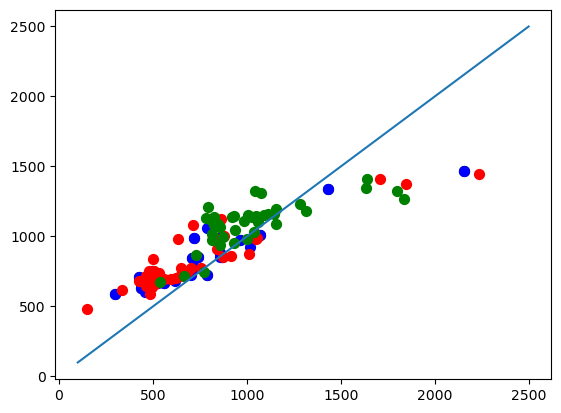

In [26]:

'''Prediction using the best model'''
predict_labels_a=[]
predict_labels_b=[]
predict_labels_train=[]
predict_labels_val = []
model.eval()
with torch.no_grad():
    predict_labels_a.append(model(input_test_a).data.numpy())
    predict_labels_b.append(model(input_test_b).data.numpy())
    
    predict_labels_train.append(model(input_train).data.numpy())   
    predict_labels_val.append(model(input_val).data.numpy())      


actual_label_arr_train=np.round(np.asarray(train_labels*max_label).reshape(-1,1))  
predict_label_arr_train=np.round(np.asarray(predict_labels_train).reshape(-1,1)*max_label)


actual_label_arr_val=np.round(np.asarray(val_labels*max_label).reshape(-1,1))   
predict_label_arr_val=np.round(np.asarray(predict_labels_val).reshape(-1,1)*max_label)


actual_label_arr_a=np.round(np.asarray(test_cycle_life_a*max_label).reshape(-1,1))   
predict_label_arr_a=np.round(np.asarray(predict_labels_a).reshape(-1,1)*max_label)


actual_label_arr_b=np.round(np.asarray(test_cycle_life_b * max_label).reshape(-1,1))   
predict_label_arr_b=np.round(np.asarray(predict_labels_b).reshape(-1,1)*max_label)


'''Plot the predicted cycle lives'''
plt.scatter(actual_label_arr_train, predict_label_arr_train,s=50,c='k')
plt.scatter(actual_label_arr_val, predict_label_arr_val,s=50,c='b')
plt.scatter(actual_label_arr_a, predict_label_arr_a,s=50,c='r')
plt.scatter(actual_label_arr_b, predict_label_arr_b,s=50,c='g')
plt.plot([100,2500],[100,2500])


'''Evaluation metrics'''
mpe_a=np.mean(np.abs(predict_label_arr_a-actual_label_arr_a)/actual_label_arr_a)
mpe_b=np.mean(np.abs(predict_label_arr_b-actual_label_arr_b)/actual_label_arr_b)
mpe_train = np.mean(np.abs(predict_label_arr_train-actual_label_arr_train)/actual_label_arr_train)
mpe_val = np.mean(np.abs(predict_label_arr_val-actual_label_arr_val)/actual_label_arr_val)


rmse_a=np.sqrt(np.mean((predict_label_arr_a-actual_label_arr_a)**2))
rmse_b=np.sqrt(np.mean((predict_label_arr_b-actual_label_arr_b)**2))
rmse_train=np.sqrt(np.mean((predict_label_arr_train-actual_label_arr_train)**2))
rmse_val=np.sqrt(np.mean((predict_label_arr_val-actual_label_arr_val)**2))


print ('mpe_train:',mpe_train)
print ('mpe_val:',mpe_val)
print ('mpe_a:',mpe_a)
print ('mpe_b:',mpe_b)

print ('rmse_train:', rmse_train)
print ('rmse_val:', rmse_val)
print ('rmse_a:', rmse_a)
print ('rmse_b:', rmse_b)

In [27]:
from sklearn.metrics import r2_score
r2_a = r2_score(actual_label_arr_a, predict_label_arr_a)
r2_b = r2_score(actual_label_arr_b, predict_label_arr_b)
r2_train = r2_score(actual_label_arr_train, predict_label_arr_train)
r2_val = r2_score(actual_label_arr_val, predict_label_arr_val)

print('r2_train:', r2_train)
print('r2_val:', r2_val)
print('r2_a:', r2_a)
print('r2_b:', r2_b)

r2_train: 0.6515334844589233
r2_val: 0.6068358421325684
r2_a: 0.6229705199002005
r2_b: 0.4175009753657175
